# <center>Занятие 24. Прогноз просрочки кредита заемщиком</center>

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import statistics 

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
RANDOM_STATE = 42

C:\Users\User\AppData\Local\Temp\ipykernel_9612\3970862297.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [3]:
df = pd.read_csv('cs-training.csv', index_col=0)

In [4]:
feature_names = df.columns[1:]
df.head(15)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [5]:
print(df.shape)
df.describe(include = "all").T

(150000, 11)


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [6]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

Согласно описанию датасета, есть столбцы с нулевыми значениями, в которых таких значений быть не должно: столбец age, MonthlyIncome, RevolvingUtilizationOfUnsecuredLines. Наличие возраста, равного нулю, нулевого баланса по картам или нулевого дохода в рамках датасета по кредитам не является корректным и будет считаться пропуском данных.

Проверим наличие NaN, при необходимости осуществите замену

In [7]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

В соответствии с данными, пропуски NAN у нас есть в столбцах MonthlyIncome и NumberOfDependents.

In [8]:
cleaned_df = df.copy(deep = True)

# Для MonthlyIncome пропуски заменим наиболее часто встречающимся значением
cleaned_df["MonthlyIncome"].fillna(statistics.mode(cleaned_df["MonthlyIncome"]), inplace=True)

# Для NumberOfDependents пропуски заменим наиболее часто встречающимся значением
cleaned_df["NumberOfDependents"].fillna(statistics.mode(cleaned_df["NumberOfDependents"]), inplace=True)

Заменим оставшиеся пропуски данных(не NAN) в столбцах age, MonthlyIncome, RevolvingUtilizationOfUnsecuredLines.

In [9]:
#в столбце age заменим нулевые элементы наиболее часто встречающимся значением 
cleaned_df.loc[cleaned_df['age'] == 0, 'age'] = statistics.mode(cleaned_df["age"])

#в столбце MonthlyIncome заменим нулевые элементы средним значением 
cleaned_df.loc[cleaned_df['MonthlyIncome'] == 0, 'MonthlyIncome'] = statistics.mean(cleaned_df["MonthlyIncome"])

#в столбце RevolvingUtilizationOfUnsecuredLines заменим нулевые элементы средним значением 
cleaned_df.loc[cleaned_df['RevolvingUtilizationOfUnsecuredLines'] == 0, 'RevolvingUtilizationOfUnsecuredLines'] = statistics.mode(cleaned_df['RevolvingUtilizationOfUnsecuredLines'])

Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [10]:
cleaned_df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

Проверьте качество замены переменных

In [11]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  float64
dtype

Таким образом видим, что после проведенных манипуляций пропусков данных у нас не осталось. 

__Визуализация данных__

Используя  seaborn.pairplot (sns) визуализируйте данные

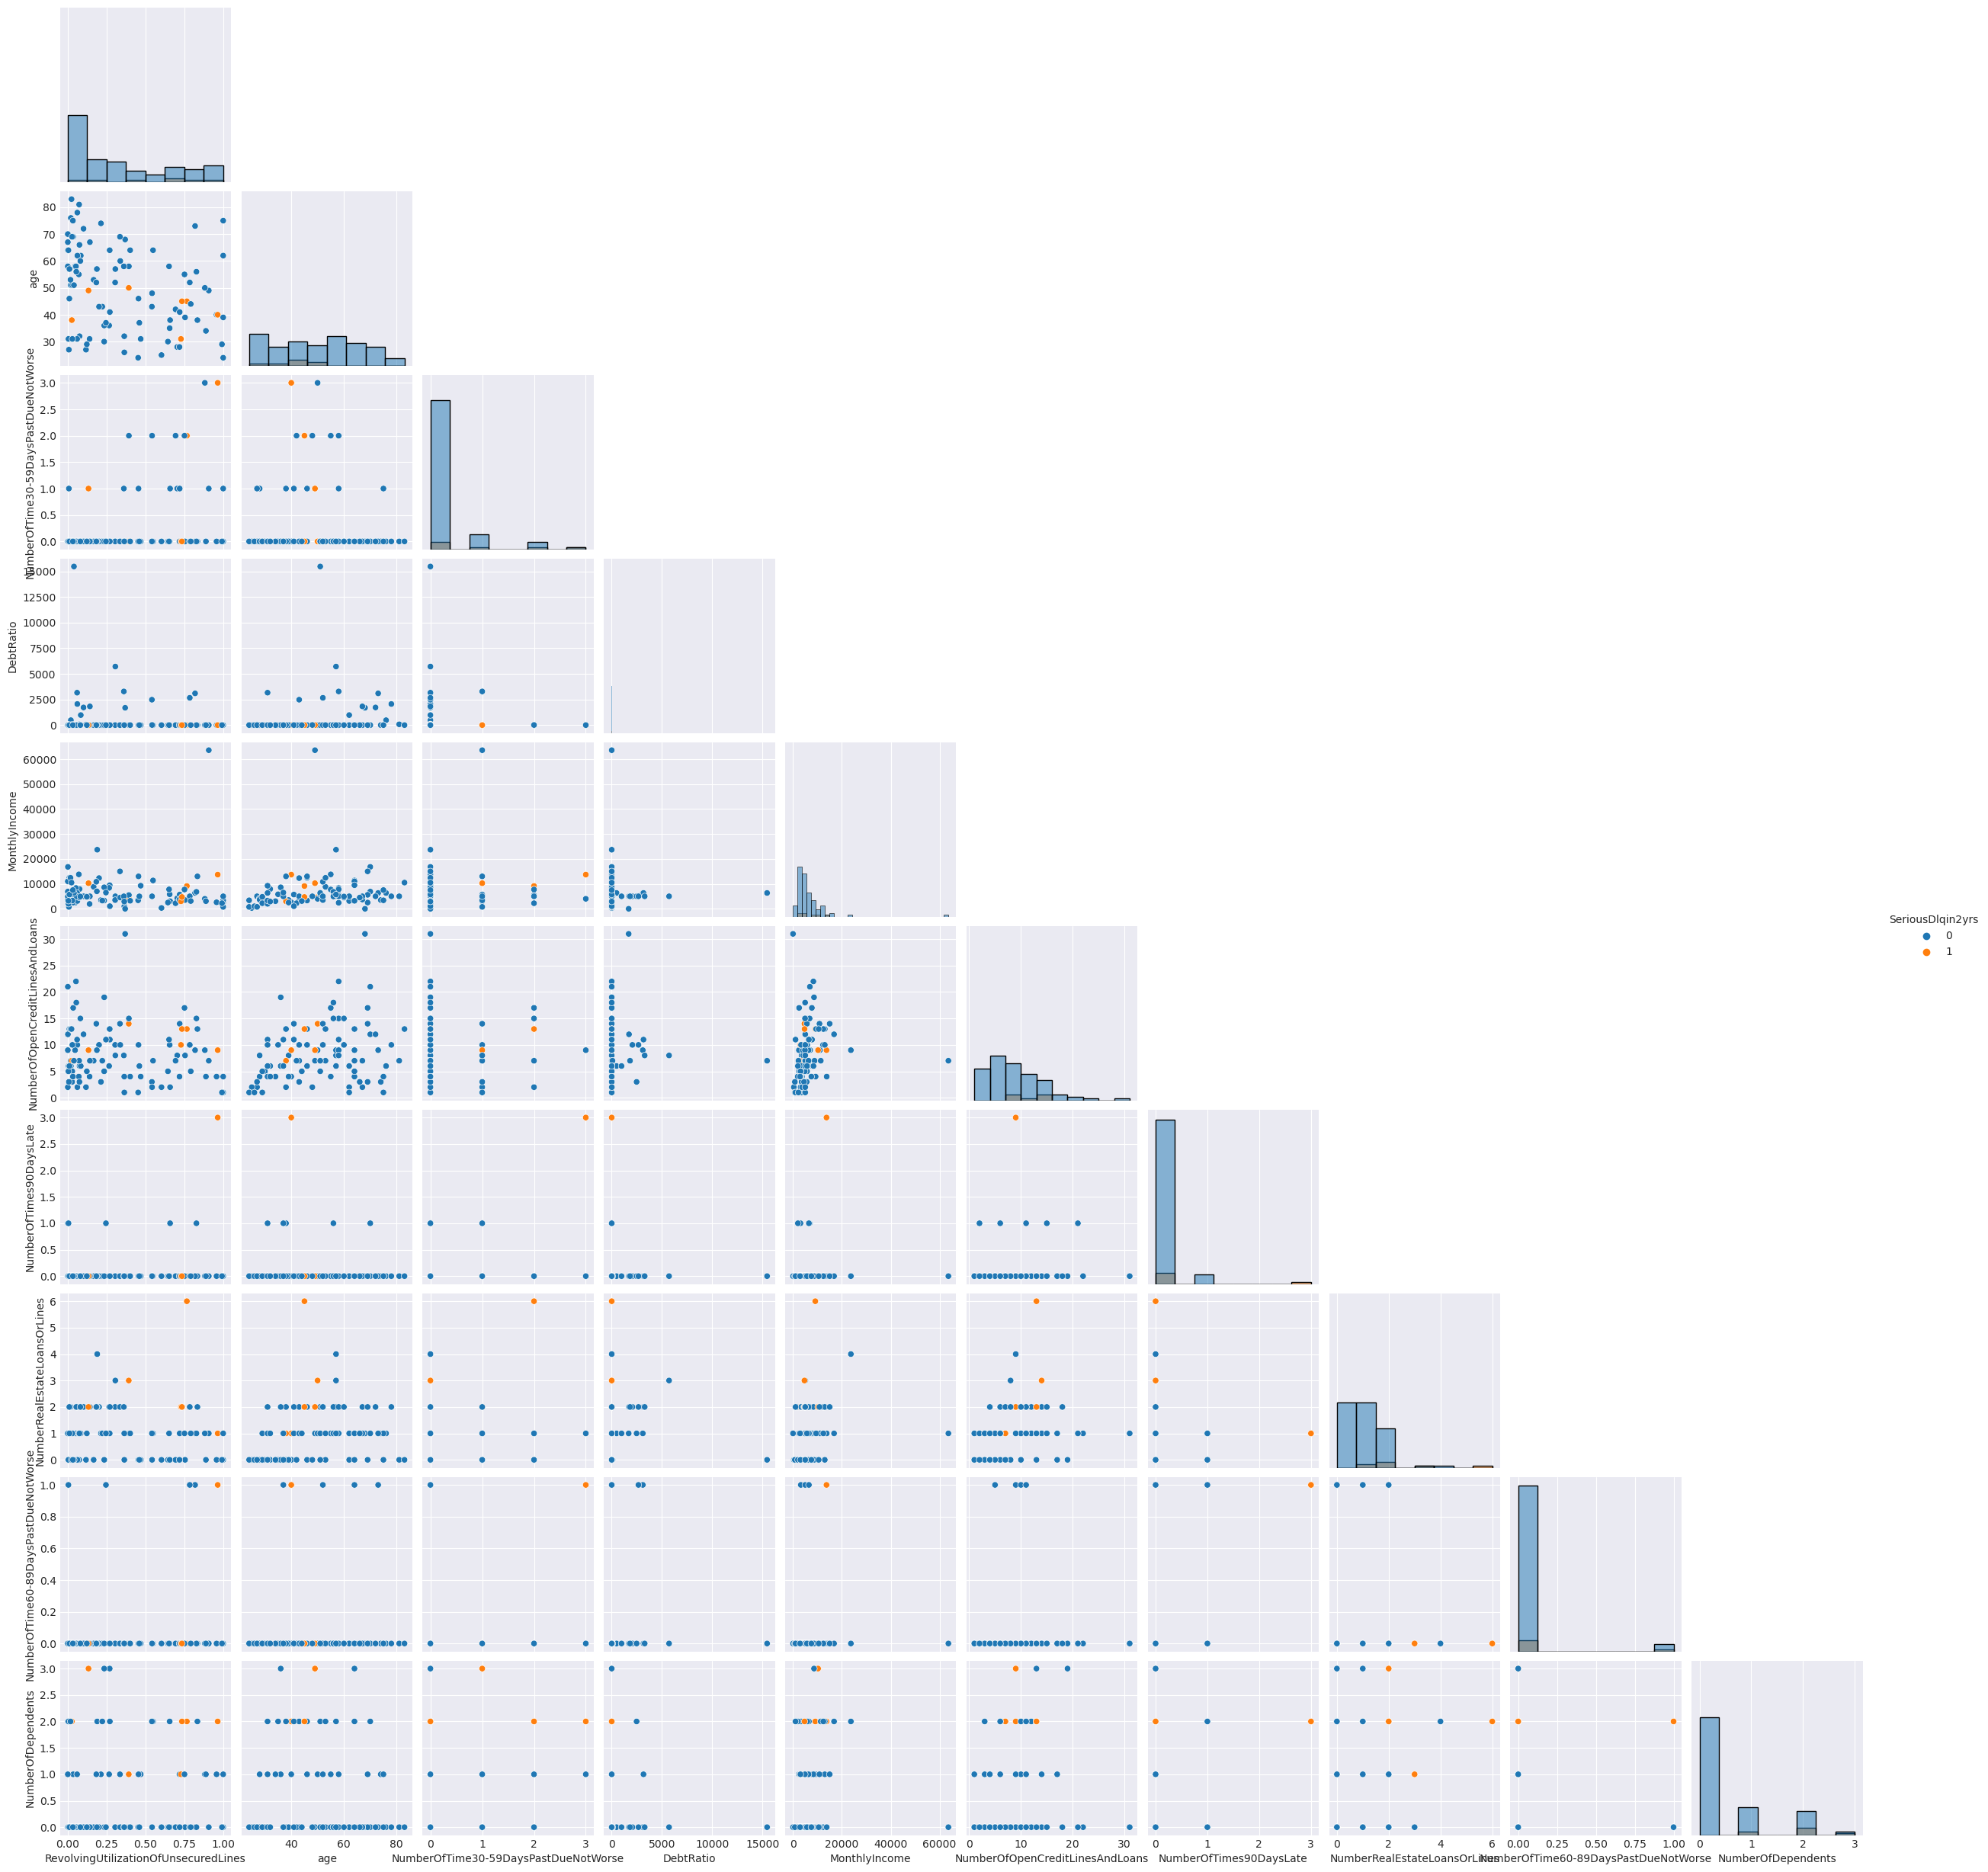

In [12]:
sns.pairplot(cleaned_df[:100], hue='SeriousDlqin2yrs', diag_kind='hist', corner=True)

Используя sns.heatmap постройте корреляционную матрицу

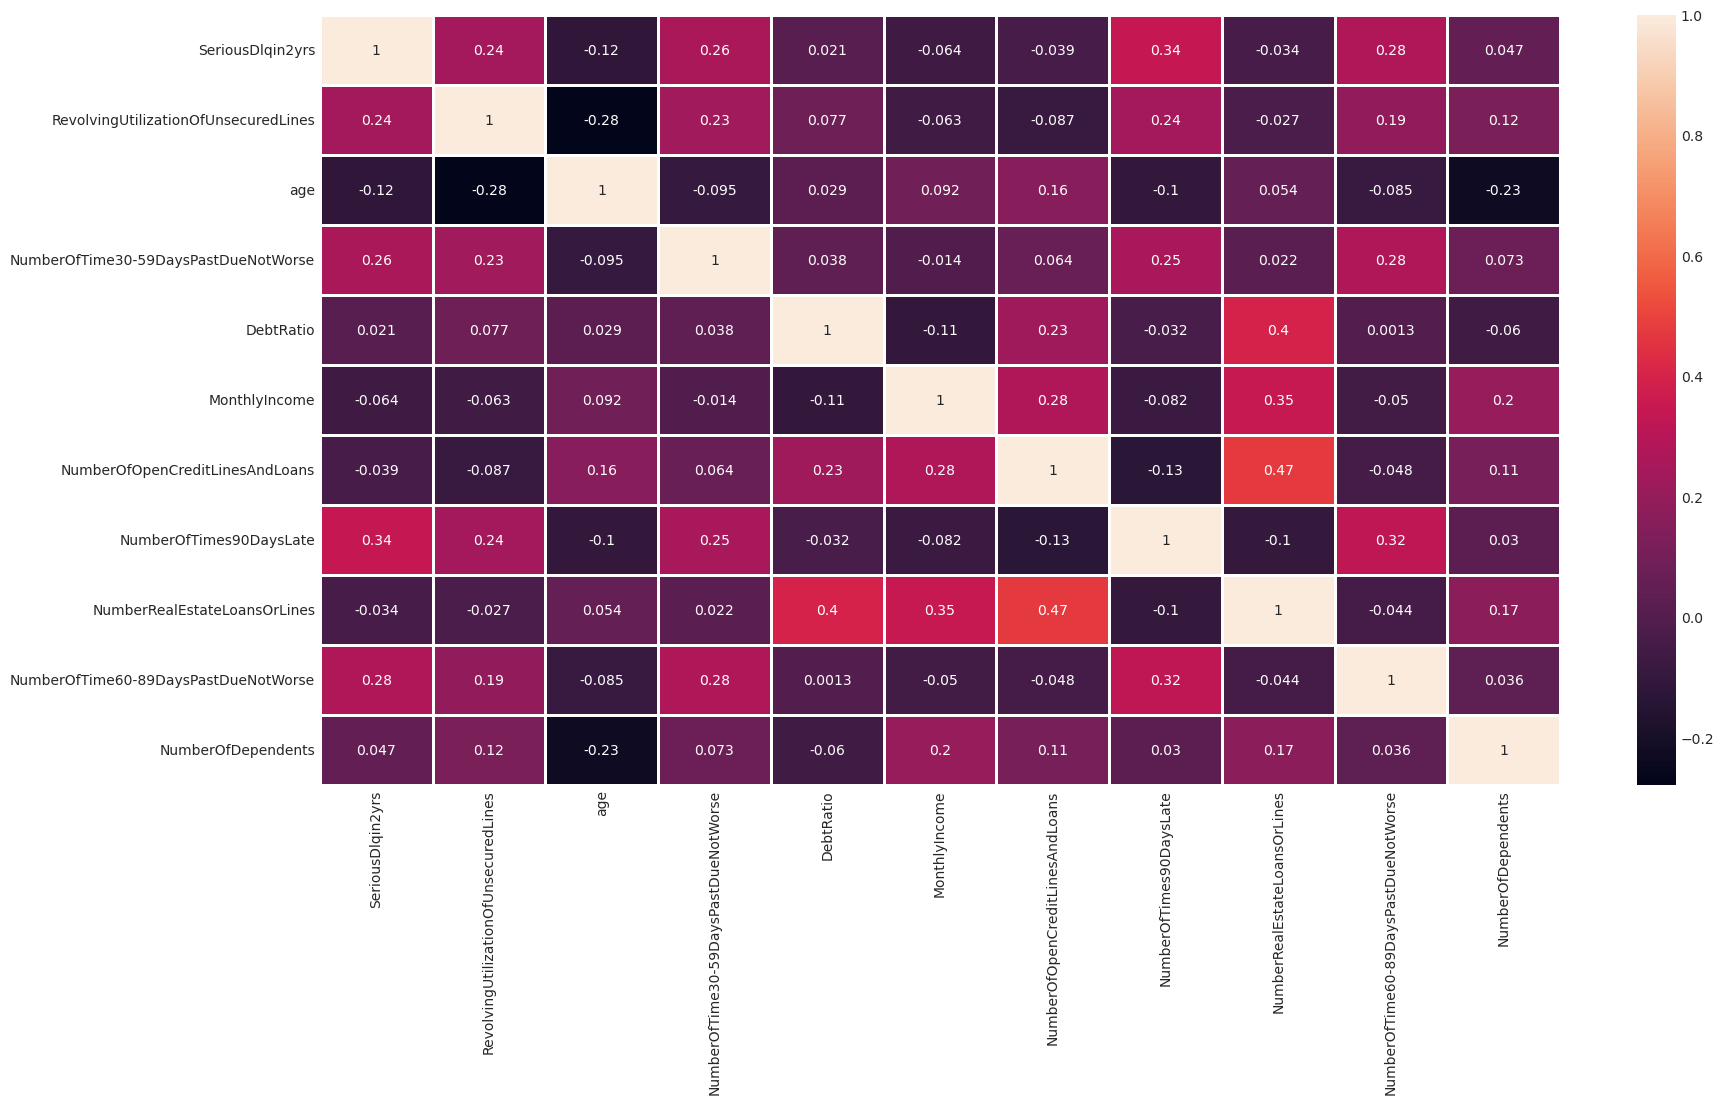

In [13]:
#corr_matrix = cleaned_df.corr()

plt.figure(figsize=(20,10), dpi=100)
corr = cleaned_df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

#sns.heatmap(cleaned_df.corr(), annot=True, linewidths=1)

Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

В соответствии с корреляционной матрицей,у целевой переменной есть прямая зависимость от общего баланса по кредитным картам и кредитным линиям, а так же от количества просрочек в 30-59 дней.
Так же есть обратная зависимость общего баланса по кредитным картам от возраста и обратная зависимость кодичества иждивенцев от возраста.

__Предобработка данных__

Оцените распределение признаков. Удалите коррелированные! Выберите способ нормализации. Подготовьте данные для обучения выбранных моделей...

array([[<AxesSubplot: title={'center': 'SeriousDlqin2yrs'}>,
        <AxesSubplot: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <AxesSubplot: title={'center': 'age'}>],
       [<AxesSubplot: title={'center': 'NumberOfTime30-59DaysPastDueNotWorse'}>,
        <AxesSubplot: title={'center': 'DebtRatio'}>,
        <AxesSubplot: title={'center': 'MonthlyIncome'}>],
       [<AxesSubplot: title={'center': 'NumberOfOpenCreditLinesAndLoans'}>,
        <AxesSubplot: title={'center': 'NumberOfTimes90DaysLate'}>,
        <AxesSubplot: title={'center': 'NumberRealEstateLoansOrLines'}>],
       [<AxesSubplot: title={'center': 'NumberOfTime60-89DaysPastDueNotWorse'}>,
        <AxesSubplot: title={'center': 'NumberOfDependents'}>,
        <AxesSubplot: >]], dtype=object)

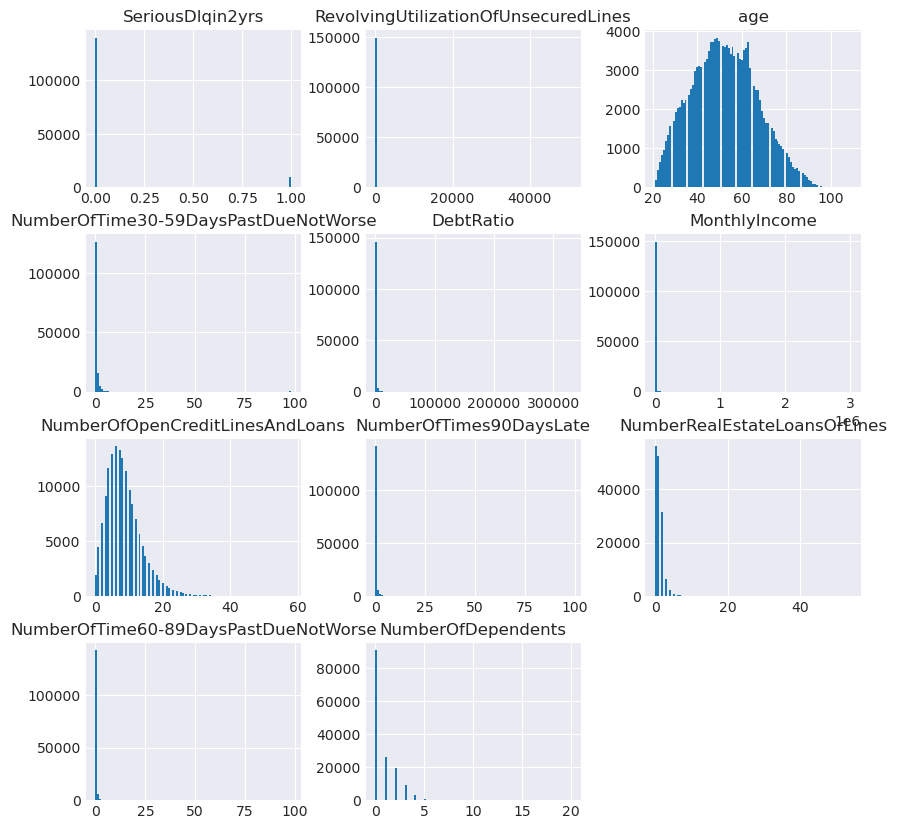

In [14]:
cols = cleaned_df.columns.values.tolist()

cleaned_df[cols].hist(bins=100, figsize=(10,10))

In [15]:
#стандартным скалером нормализуем числовые признаки
scaler = StandardScaler()
y = cleaned_df["SeriousDlqin2yrs"]

X = cleaned_df.drop(["SeriousDlqin2yrs"], axis=1)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, train_size=0.7)

__Выбор метрики__

В качестве метрики используется ROC-AUC score, согласно соренованию. Данная метрика подходит для данной задачи, так как мы хотим определять тех заемщиков, которые сильно задержат выплату кредита, но при этом выдавать кредиты хорошим клиентам. Также эта метрика хорошо работает со случаем несбалансированных классов (как в нашем случае).
Выберите способ перекрестной проверки! Какой из них подходит наилучшим образом...

In [16]:
from sklearn.model_selection import cross_val_score

Обучите 2 классификатора логистическую регрессию и случайный лес.
Для визуализации процесса обучения используйте прогрессбар tqdm

## RandomForestClassifier

In [17]:
rfc = RandomForestClassifier(random_state=42)                            
rfc.fit(X_train, y_train);

y_predicted_rfc = rfc.predict_proba(X_test)[:, 1]

print('AUC на тестовой выборке: {:.3f}'.
      format(metrics.roc_auc_score(y_test, y_predicted_rfc)))

AUC на тестовой выборке: 0.839


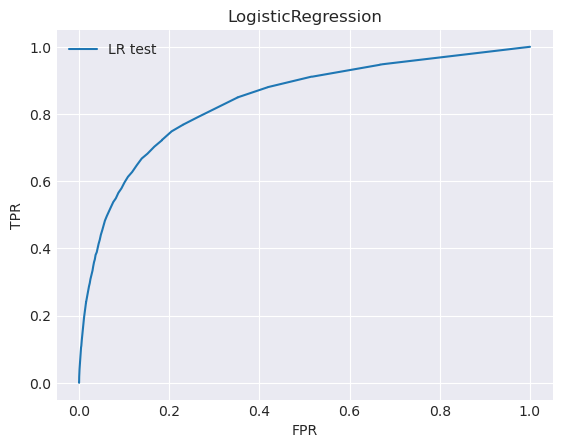

[0.82963379 0.83269629 0.8480011  0.84619143 0.84156807]


In [18]:
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_predicted_rfc)

plt.title('LogisticRegression')
plt.plot(fpr_test, tpr_test, label='LR test')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Перекрестная оценка используя скоринг ROC_AUC
scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(scores)

## LogisticRegression

In [19]:
lr = LogisticRegression(max_iter=1000)                            
lr.fit(X_train, y_train);

y_predicted_test = lr.predict_proba(X_test)[:, 1]

print('AUC на тестовой выборке: {:.3f}'.
      format(metrics.roc_auc_score(y_test, y_predicted_test)))

AUC на тестовой выборке: 0.695


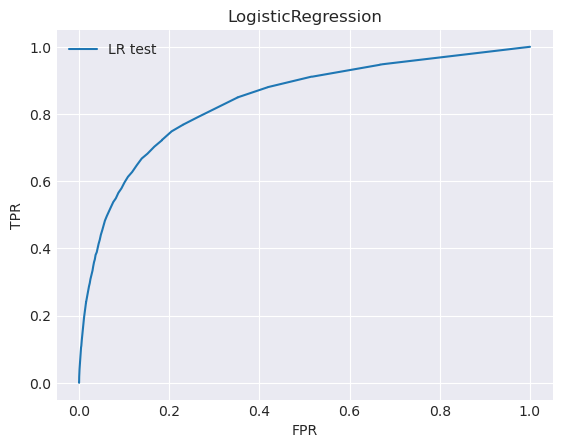

[0.70016817 0.69472306 0.69783242 0.70980457 0.69927557]


In [20]:
lr_fpr_test, lr_tpr_test, _ = metrics.roc_curve(y_test, y_predicted_rfc)

plt.title('LogisticRegression')
plt.plot(lr_fpr_test, lr_tpr_test, label='LR test')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Перекрестная оценка используя скоринг ROC_AUC
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(scores)

__Кросс-валидация и подбор параметров__

Произведите подбор параметров. Для логистической регрессии подберем коэффициент регуляризции, для случайного леса -максимальную глубину и максимальное кол-во признаков. Для отслеживания процесса обучения используйте прогрессбар, а также %%time

In [21]:
# подбор паметров модели случайного леса
rfc_params = [
     {'max_features': ['auto','log2','sqrt'], #максимальное количество число признаков для разбиения
      'max_depth': range (2, 10, 1)}] #максимальная глубина

rfc_gridsearch = GridSearchCV(rfc, param_grid=rfc_params, scoring='roc_auc', n_jobs=-1, cv=5, verbose=5)
rfc_gridsearch.fit(X_train,y_train)

print('Best Parameters : {}'.format(rfc_gridsearch.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(rfc_gridsearch.best_score_))
print('AUC на тестовой выборке: {:.3f}'.
    format(metrics.roc_auc_score(y_test, rfc_gridsearch.predict(X_test))))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters : {'max_depth': 9, 'max_features': 'auto'}
Best Accuracy Through Grid Search : 0.863

AUC на тестовой выборке: 0.579


In [22]:
lr_params = [
     { 'penalty': ['l2', 'l1'],
       'solver':['liblinear'],
       'C':[0.001, 0.01, 0.05, 0.1, 1.0, 10.0, 50, 100]}]

lr_gridsearch = GridSearchCV(lr, param_grid=lr_params, scoring='roc_auc', n_jobs=-1, cv=5, verbose=5)
lr_gridsearch.fit(X_train,y_train)

print('Best Parameters : {}'.format(lr_gridsearch.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(lr_gridsearch.best_score_))
print('AUC на тестовой выборке: {:.3f}'.
    format(metrics.roc_auc_score(y_test, lr_gridsearch.predict(X_test))))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters : {'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy Through Grid Search : 0.702

AUC на тестовой выборке: 0.512


__Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

In [23]:
new_features_df = cleaned_df.copy(deep = True)

new_features_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295533,0.421033,353.005076,6.408227e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,0.249746,249.755371,14.771251,4.192781,2037.818523,1.288048e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,21.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,4.000000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.000000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [24]:
new_features_df.T

,1,2,3,4,5,6,7,8,9,10,...,149991,149992,149993,149994,149995,149996,149997,149998,149999,150000
SeriousDlqin2yrs,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
RevolvingUtilizationOfUnsecuredLines,0.766127,0.957151,0.658180,0.23381,0.907239,0.213179,0.305682,0.754464,0.116951,0.189169,...,0.055518,0.104112,0.871976,1.0,0.385742,0.040674,0.299745,0.246044,0.0,0.850283
age,45.000000,40.000000,38.000000,30.00000,49.000000,74.000000,57.000000,39.000000,27.000000,57.000000,...,46.000000,59.000000,50.000000,22.0,50.000000,74.000000,44.000000,58.000000,30.0,64.000000
NumberOfTime30-59DaysPastDueNotWorse,2.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
DebtRatio,0.802982,0.121876,0.085113,0.03605,0.024926,0.375607,5710.000000,0.209940,46.000000,0.606291,...,0.609779,0.477658,4132.000000,0.0,0.404293,0.225131,0.716562,3870.000000,0.0,0.249908
MonthlyIncome,9120.000000,2600.000000,3042.000000,3300.00000,63588.000000,3500.000000,5000.000000,3500.000000,5000.000000,23684.000000,...,4335.000000,10316.000000,5000.000000,820.0,3400.000000,2100.000000,5584.000000,5000.000000,5716.0,8158.000000
NumberOfOpenCreditLinesAndLoans,13.000000,4.000000,2.000000,5.00000,7.000000,3.000000,8.000000,8.000000,2.000000,9.000000,...,7.000000,10.000000,11.000000,1.0,7.000000,4.000000,4.000000,18.000000,4.0,8.000000
NumberOfTimes90DaysLate,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
NumberRealEstateLoansOrLines,6.000000,0.000000,0.000000,0.00000,1.000000,1.000000,3.000000,0.000000,0.000000,4.000000,...,1.000000,2.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.000000,0.0,2.000000
NumberOfTime60-89DaysPastDueNotWorse,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Оценим количество кредитов по количеству лиц на иждивении

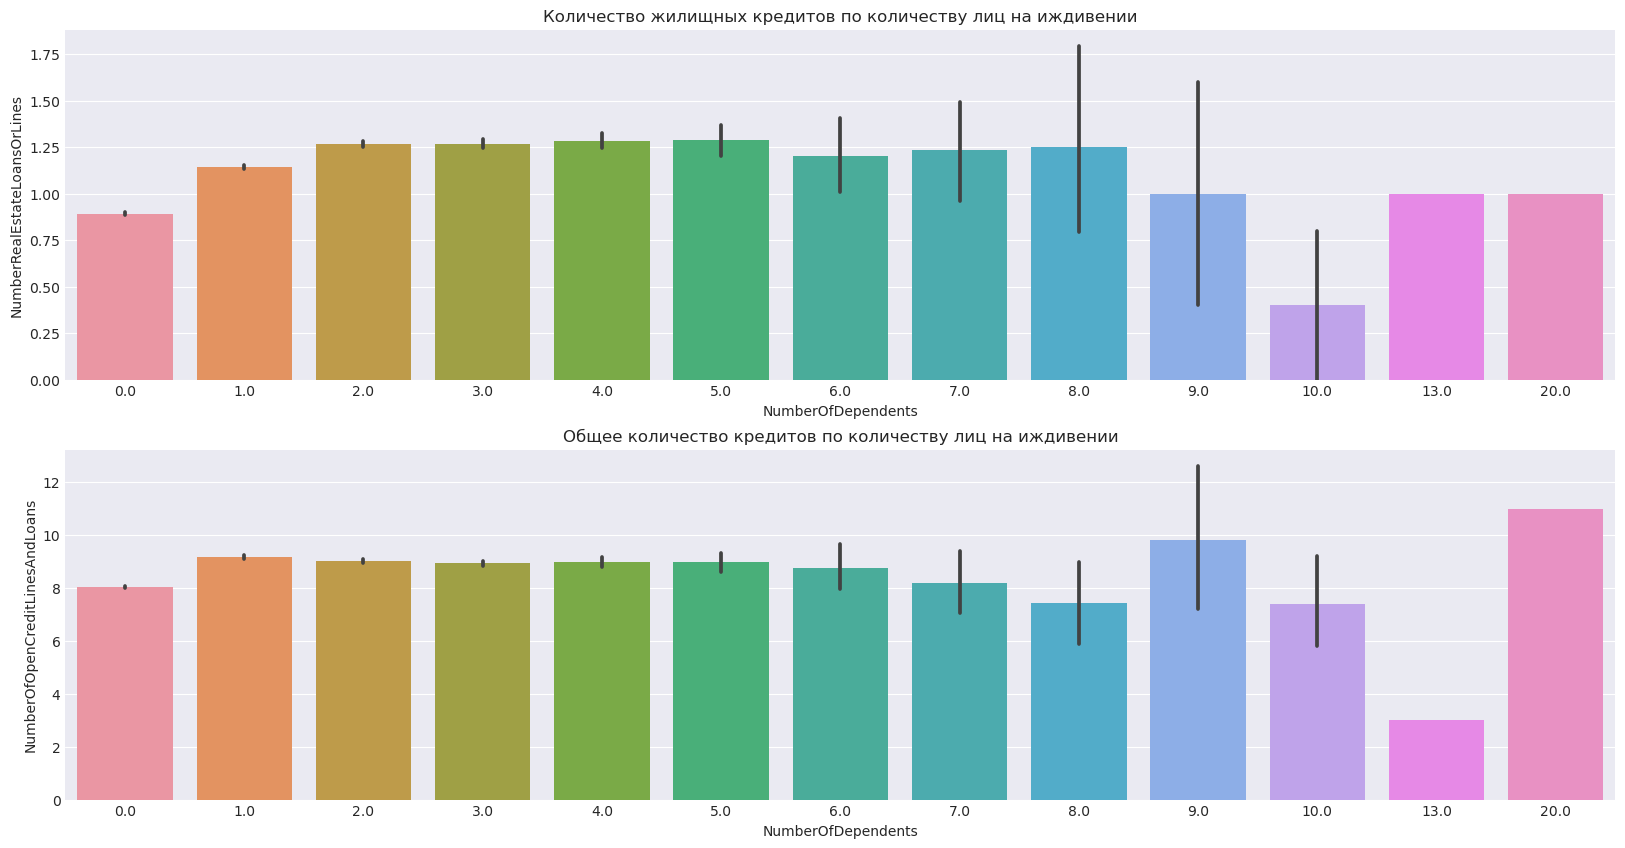

In [25]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.barplot(data = new_features_df, x = new_features_df.NumberOfDependents, y ='NumberRealEstateLoansOrLines');
plt.title ('Количество жилищных кредитов по количеству лиц на иждивении');

plt.subplot (2,1,2)
sns.barplot(data = new_features_df, x = new_features_df.NumberOfDependents, y='NumberOfOpenCreditLinesAndLoans');
plt.title ('Общее количество кредитов по количеству лиц на иждивении');

Исходя из представленных выше графиков, у лиц без или с девятью иждивенцами и более меньше всего кредитов на жилье. 
А у лиц с 9 и 20 иждивенцами больше всего других кредитов.
Разобьем количество прострочек на три периода: от 30 до 59 дней, от 60 до 80 дней, более 90 дней
Количество иждивенцев так же разобьем на две группы: от 0 до 10 иждивенцев и от 10 до 20 иждивенцев(20 - максимально число иждивенцев в датасете).

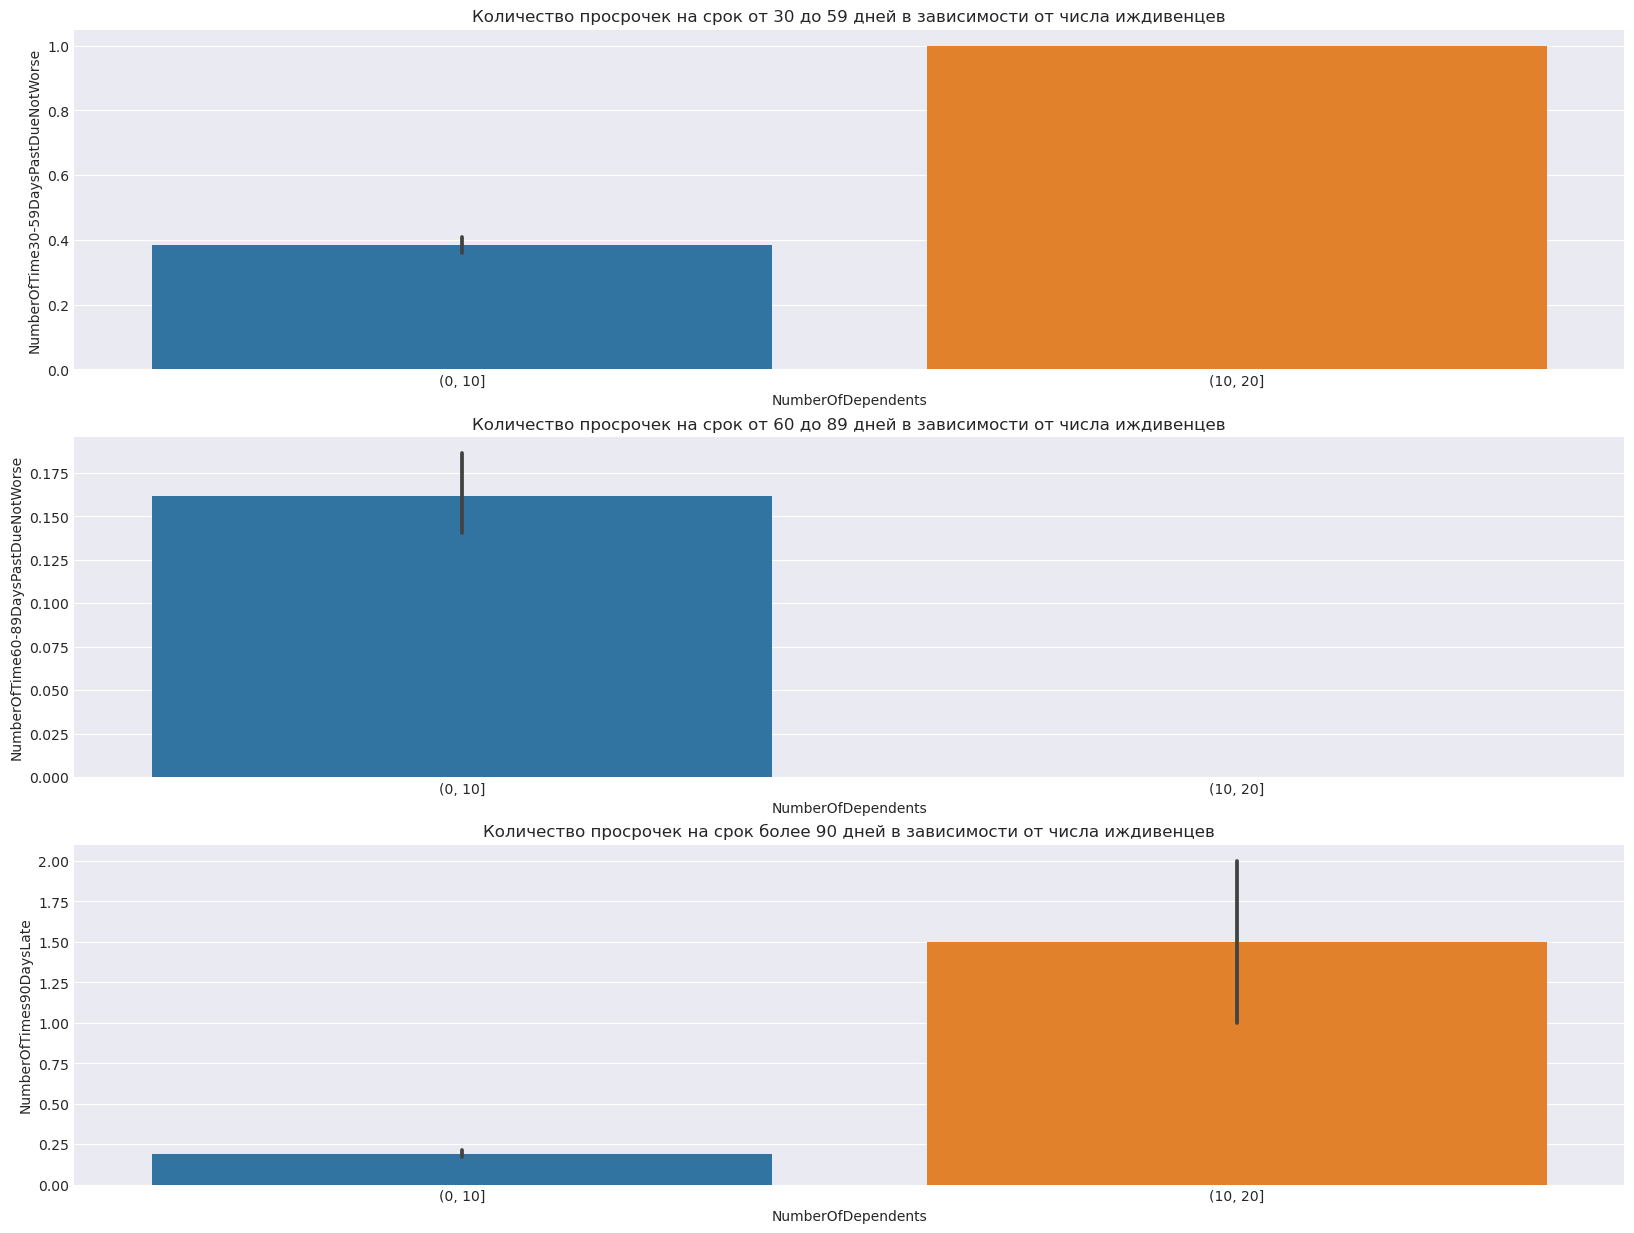

In [26]:
plt.figure(figsize=(20,15))

binned_val = pd.cut(new_features_df.NumberOfDependents, 
                   bins = [0,10,20])

plt.subplot (3,1,1)
sns.barplot(data = new_features_df, x=binned_val, y='NumberOfTime30-59DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 30 до 59 дней в зависимости от числа иждивенцев');


plt.subplot (3,1,2)
sns.barplot(data = new_features_df, x=binned_val, y='NumberOfTime60-89DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 60 до 89 дней в зависимости от числа иждивенцев');

plt.subplot (3,1,3)
sns.barplot(data = new_features_df, x=binned_val, y='NumberOfTimes90DaysLate')
plt.title ('Количество просрочек на срок более 90 дней в зависимости от числа иждивенцев');

In [27]:
#разобье кодичество инждивенцев на две группы: от 0 до 9 и от 10 до 20 иждивенцев
new_features_df.loc[(new_features_df.NumberOfDependents>=0) & (new_features_df.NumberOfDependents<=10), 'BinNumberOfDependents'] = 1
new_features_df.loc[(new_features_df.NumberOfDependents>=11), 'BinNumberOfDependents'] = 2

Отобразим количество открытых кредитных линий общих и по недвижимости

<AxesSubplot: xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

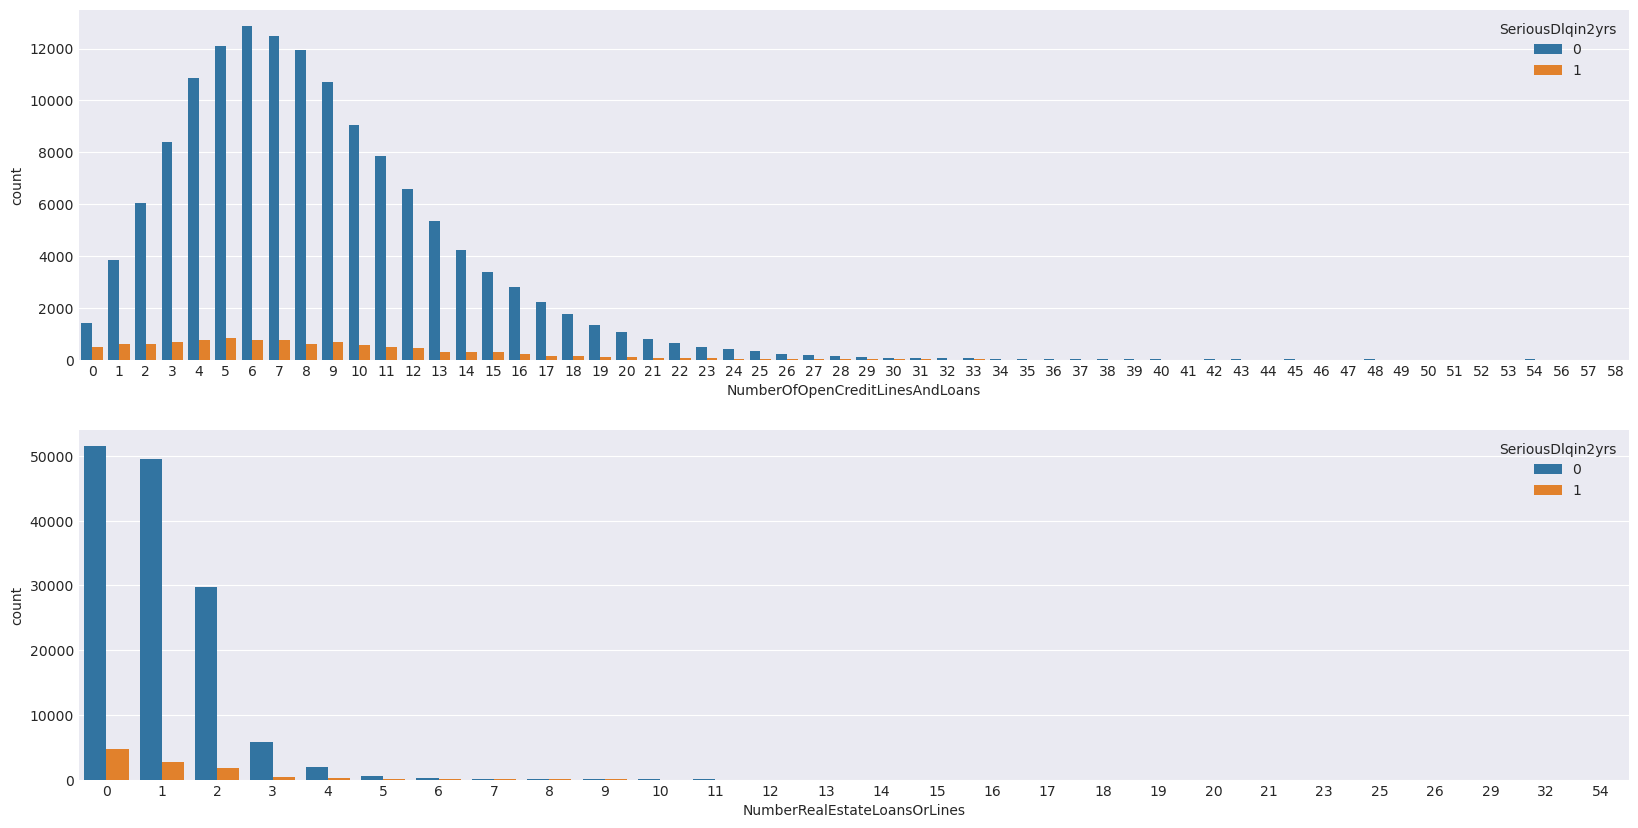

In [28]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=new_features_df['NumberOfOpenCreditLinesAndLoans'], hue=new_features_df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=new_features_df['NumberRealEstateLoansOrLines'], hue=new_features_df.SeriousDlqin2yrs)

In [29]:
new_features_df.loc[(new_features_df.NumberOfOpenCreditLinesAndLoans>=0) & (new_features_df.NumberOfOpenCreditLinesAndLoans<=12), 'BinNumberOfOpenCreditLinesAndLoans']=1
new_features_df.loc[(new_features_df.NumberOfOpenCreditLinesAndLoans>=13) & (new_features_df.NumberOfOpenCreditLinesAndLoans<=20), 'BinNumberOfOpenCreditLinesAndLoans']=2
new_features_df.loc[(new_features_df.NumberOfOpenCreditLinesAndLoans>=21), 'BinNumberOfOpenCreditLinesAndLoans']=3

new_features_df.loc[(new_features_df.NumberRealEstateLoansOrLines>=0) & (new_features_df.NumberRealEstateLoansOrLines<=2), 'BinNumberRealEstateLoansOrLines']=1
new_features_df.loc[(new_features_df.NumberRealEstateLoansOrLines>=3), 'BinNumberRealEstateLoansOrLines']=2

In [30]:
X=new_features_df.drop(['SeriousDlqin2yrs','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'],axis=1)
y=new_features_df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
parameters = {"C":np.logspace(-3,3,7)}
pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(lr,parameters,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.933 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.933 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.933 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.933 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.933 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.933 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.933 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.933 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.933 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.933 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.934 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                              verbose=3))])

In [38]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.6959710740171665

In [39]:
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,4]
}

pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(rfc,param_grid,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END ....max_depth=1, max_features=auto;, score=0.933 total time=   1.1s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END ....max_depth=1, max_features=auto;, score=0.933 total time=   1.1s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END ....max_depth=1, max_features=auto;, score=0.933 total time=   1.1s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END ....max_depth=1, max_features=auto;, score=0.933 total time=   1.1s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END ....max_depth=1, max_features=auto;, score=0.933 total time=   1.1s
[CV 1/5] END ....max_depth=1, max_features=sqrt;, score=0.933 total time=   1.1s
[CV 2/5] END ....max_depth=1, max_features=sqrt;, score=0.933 total time=   1.1s
[CV 3/5] END ....max_depth=1, max_features=sqrt;, score=0.933 total time=   1.1s
[CV 4/5] END ....max_depth=1, max_features=sqrt;, score=0.933 total time=   1.1s
[CV 5/5] END ....max_depth=1, max_features=sqrt;, score=0.933 total time=   1.1s
[CV 1/5] END ....max_depth=1, max_features=log2;, score=0.933 total time=   1.1s
[CV 2/5] END ....max_depth=1, max_features=log2;, score=0.933 total time=   1.1s
[CV 3/5] END ....max_depth=1, max_features=log2;, score=0.933 total time=   1.1s
[CV 4/5] END ....max_depth=1, max_features=log2;, score=0.933 total time=   1.1s
[CV 5/5] END ....max_depth=1, max_features=log2;, score=0.933 total time=   1.1s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END ....max_depth=2, max_features=auto;, score=0.933 total time=   1.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END ....max_depth=2, max_features=auto;, score=0.933 total time=   1.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END ....max_depth=2, max_features=auto;, score=0.933 total time=   1.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END ....max_depth=2, max_features=auto;, score=0.933 total time=   1.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END ....max_depth=2, max_features=auto;, score=0.933 total time=   1.6s
[CV 1/5] END ....max_depth=2, max_features=sqrt;, score=0.933 total time=   1.6s
[CV 2/5] END ....max_depth=2, max_features=sqrt;, score=0.933 total time=   1.6s
[CV 3/5] END ....max_depth=2, max_features=sqrt;, score=0.933 total time=   1.5s
[CV 4/5] END ....max_depth=2, max_features=sqrt;, score=0.933 total time=   1.6s
[CV 5/5] END ....max_depth=2, max_features=sqrt;, score=0.933 total time=   1.6s
[CV 1/5] END ....max_depth=2, max_features=log2;, score=0.933 total time=   1.6s
[CV 2/5] END ....max_depth=2, max_features=log2;, score=0.933 total time=   1.6s
[CV 3/5] END ....max_depth=2, max_features=log2;, score=0.933 total time=   1.5s
[CV 4/5] END ....max_depth=2, max_features=log2;, score=0.933 total time=   1.6s
[CV 5/5] END ....max_depth=2, max_features=log2;, score=0.933 total time=   1.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END ....max_depth=4, max_features=auto;, score=0.936 total time=   2.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END ....max_depth=4, max_features=auto;, score=0.936 total time=   2.5s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END ....max_depth=4, max_features=auto;, score=0.935 total time=   2.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END ....max_depth=4, max_features=auto;, score=0.936 total time=   2.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END ....max_depth=4, max_features=auto;, score=0.934 total time=   2.6s
[CV 1/5] END ....max_depth=4, max_features=sqrt;, score=0.936 total time=   2.6s
[CV 2/5] END ....max_depth=4, max_features=sqrt;, score=0.936 total time=   2.5s
[CV 3/5] END ....max_depth=4, max_features=sqrt;, score=0.935 total time=   2.5s
[CV 4/5] END ....max_depth=4, max_features=sqrt;, score=0.936 total time=   2.6s
[CV 5/5] END ....max_depth=4, max_features=sqrt;, score=0.934 total time=   2.6s
[CV 1/5] END ....max_depth=4, max_features=log2;, score=0.936 total time=   2.6s
[CV 2/5] END ....max_depth=4, max_features=log2;, score=0.936 total time=   2.6s
[CV 3/5] END ....max_depth=4, max_features=log2;, score=0.935 total time=   2.5s
[CV 4/5] END ....max_depth=4, max_features=log2;, score=0.936 total time=   2.6s
[CV 5/5] END ....max_depth=4, max_features=log2;, score=0.934 total time=   2.6s


D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              param_grid={'max_depth': [1, 2, 4],
                                          'max_features': ['auto', 'sqrt',
                                                           'log2']},
                              verbose=3))])

In [40]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.8558144252177774

Как улучшилось качество модели?

После дополнения датасета дополнительных признаков и их бинаризации в целом улучшило показатели AUC, особенно это заметно на запуске модели случайного леса.